In [1]:
import pandas as pd
import os
import re
import unicodedata
from rapidfuzz import fuzz, process as fuzzprocess
import numpy as np

In [2]:

_re_non_alnum = re.compile(r"[^0-9a-z]+")
_re_multi_unders = re.compile(r"_+")

def normalizar_texto(texto: str) -> str:
    """Normaliza texto : sin acentos, minúsculas, underscores limpios."""
    if not isinstance(texto, str):
        return texto

    texto = unicodedata.normalize("NFKD", texto)
    texto = "".join(c for c in texto if not unicodedata.combining(c))
    texto = texto.lower()

    texto = _re_non_alnum.sub("_", texto)
    texto = _re_multi_unders.sub("_", texto)
    return texto.strip("_")

In [3]:
""""

Vehículos homologados antes de ~2014 COLUMNA AM.
Vehículos homologados 2014 en adelante COLUMNA  AH.
Vehículos 100 % eléctricos o de hidrógeno = 0"""

"""
Si la columna “Año modelo” ≥ 2015 → usa columna AH (WLTP)
Si la columna “Año modelo” ≤ 2014 → usa columna AM (NEDC o FTP-75)
Si “Tecnología” = BEV (Battery Electric Vehicle) o FCEV → emisiones = 0

"""

'\nSi la columna “Año modelo” ≥ 2015 → usa columna AH (WLTP)\nSi la columna “Año modelo” ≤ 2014 → usa columna AM (NEDC o FTP-75)\nSi “Tecnología” = BEV (Battery Electric Vehicle) o FCEV → emisiones = 0\n\n'

# Limpieza datos NOMINA DE VEHICULOS

### llenar valores faltantes CO2


In [4]:
nomina_vehiculos = pd.read_excel("../utils/Nomina_vehiculos.xlsx")
nomina_vehiculos.head()

,id_modelo,marca,modelo,Transmisión,Combustible,Propulsión,Cilindrada,Carroceria,Emisiones de CO2 (g/km),CO2 combinado,Categoria_año,año_abajo,año_arriba
0,3299,Jaguar,"XF 2,2 Lts. DOHC Sedán 4P. T/A Motor Diésel",A,Diésel,Combustión,2.2,Sedán,139,-,2013-2025,2013,2025
1,3300,Jaguar,"XF 2,0T Lts. DOHC Sedán 4P. T/A Motor Otto",A,Gasolina,Combustión,2.0,Sedán,207,-,2013-2025,2013,2025
2,3301,Land Rover,"Freelander 2 2,0 Lts. DOHC Station Wagon 5P. 4...",A,Gasolina,Combustión,2.0,Station Wagon,224,-,2013-2025,2013,2025
3,3302,Piaggio,"Porter Maxxi Tipper Long Deck 1,3 Lts. DOHC Pi...",M,Gasolina,Combustión,1.3,Camioneta,227,-,2013-2025,2013,2025
4,NaN,Piaggio,"Porter Maxxi Chasis Cabina 1,3 Lts. DOHC Pick ...",M,Gasolina,Combustión,1.3,Camioneta,227,-,2013-2025,2013,2025


In [5]:
nomina_vehiculos_cols_nom = [normalizar_texto(col) for col in nomina_vehiculos.columns]
nomina_vehiculos.columns = nomina_vehiculos_cols_nom
nomina_vehiculos.head()

,id_modelo,marca,modelo,transmision,combustible,propulsion,cilindrada,carroceria,emisiones_de_co2_g_km,co2_combinado,categoria_ano,ano_abajo,ano_arriba
0,3299,Jaguar,"XF 2,2 Lts. DOHC Sedán 4P. T/A Motor Diésel",A,Diésel,Combustión,2.2,Sedán,139,-,2013-2025,2013,2025
1,3300,Jaguar,"XF 2,0T Lts. DOHC Sedán 4P. T/A Motor Otto",A,Gasolina,Combustión,2.0,Sedán,207,-,2013-2025,2013,2025
2,3301,Land Rover,"Freelander 2 2,0 Lts. DOHC Station Wagon 5P. 4...",A,Gasolina,Combustión,2.0,Station Wagon,224,-,2013-2025,2013,2025
3,3302,Piaggio,"Porter Maxxi Tipper Long Deck 1,3 Lts. DOHC Pi...",M,Gasolina,Combustión,1.3,Camioneta,227,-,2013-2025,2013,2025
4,NaN,Piaggio,"Porter Maxxi Chasis Cabina 1,3 Lts. DOHC Pick ...",M,Gasolina,Combustión,1.3,Camioneta,227,-,2013-2025,2013,2025


In [6]:
nomina_vehiculos.cilindrada.unique()

array([2.2 , 2.  , 1.3 , 1.6 , 1.2 , 2.5 , 1.  , 6.7 , 3.  , 3.5 , 3.2 ,
       1.8 , 4.7 , 4.  , 1.4 , 2.4 , 4.8 , 4.2 , 1.5 , 0.  , 5.  , 5.7 ,
       1.1 , 3.4 , 2.8 , 3.8 , 4.1 , 5.9 , 2.7 , 3.6 , 2.1 , 3.3 , 1.7 ,
       6.2 , 5.3 , 5.5 , 6.3 , 4.4 , 5.2 , 3.7 , 0.9 , 6.6 , 6.  , 0.8 ,
       2.3 , 4.6 , 3.9 , 5.01, 6.5 , 5.6 , 1.9 , 2.9 , 4.3 , 5.4 , 6.1 ,
       4.5 , 6.4 , 2.6 , 0.7 , 7.  , 0.97, 3.1 ])

In [7]:
nomina_vehiculos.propulsion.unique()

array(['Combustión', 'Vehículo eléctrico',
       'Vehículos híbridos sin recarga exterior',
       'Vehículos híbrido con recarga exterior',
       'Vehículos celda de hidrógeno', 'Eléctrico de Rango Extendido',
       'Eléctrico híbrido con recarga exterior', '-'], dtype=object)

In [8]:
# Limpiar valores no numéricos en las columnas de CO2
cols_co2 = ["emisiones_de_co2_g_km", "co2_combinado"]

for col in cols_co2:
    nomina_vehiculos[col] = (
        nomina_vehiculos[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.replace("-", "", regex=False)
        .str.replace("N/D", "", regex=False)
        .str.replace("n/a", "", regex=False)
        .str.strip()
    )

    nomina_vehiculos[col] = pd.to_numeric(nomina_vehiculos[col], errors="coerce")


In [9]:
nomina_vehiculos["es_electrico"] = (
    nomina_vehiculos["propulsion"]
    .astype(str)
    .str.lower()
    .str.contains("eléctrico")
)

In [10]:
"""
-------------------------------
    VAMOS A AGREGAR LOS VALORES NULOS SACANDO EL PROMEDIO POR CILINDRADA Y TIPO DE CARROCERIA
-------------------------------

"""


nomina_vehiculos = nomina_vehiculos.copy()

# 1) Crear cilindrada agrupada
nomina_vehiculos["cilindrada_grp"] = nomina_vehiculos["cilindrada"].astype(float).round(1)

# ----------------------------------------------------------------------
# 2) Filtrar SOLO COMBUSTIÓN para calcular promedios
# ----------------------------------------------------------------------
nomina_vehiculos_comb = nomina_vehiculos[
    (nomina_vehiculos["propulsion"] != "Vehículo eléctrico") &
    (nomina_vehiculos["emisiones_de_co2_g_km"].notna())
]

# Promedio por carrocería + cilindrada + combustible
grp = (
    nomina_vehiculos_comb.groupby(["carroceria", "cilindrada_grp", "combustible"])["emisiones_de_co2_g_km"]
    .mean()
    .reset_index()
    .rename(columns={"emisiones_de_co2_g_km": "co2_prom_grupo"})
)

# Fallback por cilindrada
fallback_cil = (
    nomina_vehiculos_comb.groupby("cilindrada_grp")["emisiones_de_co2_g_km"]
    .mean()
    .reset_index()
    .rename(columns={"emisiones_de_co2_g_km": "co2_prom_cil"})
)

# Promedio global (solo combustión)
fallback_global = nomina_vehiculos_comb["emisiones_de_co2_g_km"].mean()

# ----------------------------------------------------------------------
# 3) Merge promedios SOLO a los vehículos de combustión
# ----------------------------------------------------------------------
nomina_vehiculos = nomina_vehiculos.merge(grp, on=["carroceria","cilindrada_grp","combustible"], how="left")
nomina_vehiculos = nomina_vehiculos.merge(fallback_cil, on="cilindrada_grp", how="left")







In [11]:

# ----------------------------------------------------------------------
# 4) Función final para calcular CO2
# ----------------------------------------------------------------------
def calcular_co2(row):

    # Caso especial: eléctrico → SIEMPRE 0 (sin usar promedios)
    if row["es_electrico"]:
        return 0


    # Valores crudos
    c1 = row["emisiones_de_co2_g_km"]
    c2 = row["co2_combinado"]

    # Caso 1: ambos presentes → promedio
    if pd.notna(c1) and pd.notna(c2):
        return (c1 + c2) / 2

    # Caso 2: solo co2_combinado
    if pd.isna(c1) and pd.notna(c2):
        return c2

    # Caso 3: solo emisiones
    if pd.notna(c1):
        return c1

    # Caso 4: ambos vacíos → imputación SOLO si combustión
    if row["propulsion"] == "Combustión":
        
        if pd.notna(row["co2_prom_grupo"]):
            return row["co2_prom_grupo"]

        if pd.notna(row["co2_prom_cil"]):
            return row["co2_prom_cil"]

        return fallback_global
    
    # Si no es combustión y no tiene datos → se queda NaN
    return np.nan

In [12]:
nomina_vehiculos["co2_final"] = nomina_vehiculos.apply(calcular_co2, axis=1)

print("IMPUTACIÓN LISTA ✔ Vehículos eléctricos excluidos correctamente.")

IMPUTACIÓN LISTA ✔ Vehículos eléctricos excluidos correctamente.


In [13]:
nomina_vehiculos

,id_modelo,marca,modelo,transmision,combustible,propulsion,cilindrada,carroceria,emisiones_de_co2_g_km,co2_combinado,categoria_ano,ano_abajo,ano_arriba,es_electrico,cilindrada_grp,co2_prom_grupo,co2_prom_cil,co2_final
0,3299,Jaguar,"XF 2,2 Lts. DOHC Sedán 4P. T/A Motor Diésel",A,Diésel,Combustión,2.2,Sedán,139.0,NaN,2013-2025,2013,2025,False,2.2,152.333333,215.258413,139.0
1,3300,Jaguar,"XF 2,0T Lts. DOHC Sedán 4P. T/A Motor Otto",A,Gasolina,Combustión,2.0,Sedán,207.0,NaN,2013-2025,2013,2025,False,2.0,181.324607,182.270695,207.0
2,3301,Land Rover,"Freelander 2 2,0 Lts. DOHC Station Wagon 5P. 4...",A,Gasolina,Combustión,2.0,Station Wagon,224.0,NaN,2013-2025,2013,2025,False,2.0,191.571053,182.270695,224.0
3,3302,Piaggio,"Porter Maxxi Tipper Long Deck 1,3 Lts. DOHC Pi...",M,Gasolina,Combustión,1.3,Camioneta,227.0,NaN,2013-2025,2013,2025,False,1.3,187.452830,173.140000,227.0
4,NaN,Piaggio,"Porter Maxxi Chasis Cabina 1,3 Lts. DOHC Pick ...",M,Gasolina,Combustión,1.3,Camioneta,227.0,NaN,2013-2025,2013,2025,False,1.3,187.452830,173.140000,227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,985,Subaru,"Impreza 1,6 AWD SOHC Sedán 4P. T/A Motor Otto",A,Gasolina,Combustión,1.6,Sedán,187.0,NaN,1997-2002,1997,2002,False,1.6,173.517787,169.256000,187.0
13069,986,Volkswagen,"Caddy 1,6 SOHC Furgón 3P. T/M Motor Otto Dual",M,Gasolina/GNC,Combustión,1.6,Furgón,187.0,NaN,1997-2002,1997,2002,False,1.6,187.000000,169.256000,187.0
13070,987,Citroen,"C3 1,4 SOHC Hatchback 5P. T/M Motor Otto",M,Gasolina,Combustión,1.4,Hatchback,187.0,NaN,1997-2002,1997,2002,False,1.4,153.463636,155.202733,187.0
13071,988,Kia,"Sorento 3,5 DOHC Tipo Jeep 4P. AWD T/A Motor Otto",A,Gasolina,Combustión,3.5,Station Wagon,187.0,NaN,1997-2002,1997,2002,False,3.5,244.258824,239.136646,187.0


# Region


In [14]:
# USARÉ EL EXCEL MAS RECIENTE PARA COMPRAR LA COLUMNA CON EL ID DE REGION
filepath_transpublico_oct = r"C:\Users\hsakurada\Desktop\ESTUDIO\wea\prueba-tecnica\CMS-PRUEBA-TECNICA\Normalizar datos\servicio_extraido.csv"

regiones_csv = pd.read_csv(filepath_transpublico_oct)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\hsakurada\\Desktop\\ESTUDIO\\wea\\prueba-tecnica\\CMS-PRUEBA-TECNICA\\Normalizar datos\\servicio_extraido.csv'

In [ ]:
regiones_csv.columns

Index(['region', 'folio', 'tipo_servicio', 'flota_vigente', 'nro_linea',
       'rut_responsable', 'nombre_responsable', 'nombre_fantasia',
       'tipo_persona', 'domicilio', 'comuna', 'region_1', 'telefono', 'fax',
       'email', 'año_archivo', 'mes_archivo', 'archivo', 'conca',
       'tiposervicio', 'domicilio_1', 'fecha_creacion', 'nombre_comercial'],
      dtype='object')

In [ ]:
regiones_clean = regiones_csv[['region','region_1','año_archivo','mes_archivo']]
regiones_clean.drop_duplicates(inplace=True)

regiones_clean

C:\Users\hsakurada\AppData\Local\Temp\ipykernel_39804\2820319406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regiones_clean.drop_duplicates(inplace=True)


,region,region_1,año_archivo,mes_archivo
0,1,NaN,2021,abril
28,3,NaN,2021,abril
37,3,DE ATACAMA,2021,abril
41,4,NaN,2021,abril
115,4,DE COQUIMBO,2021,abril
...,...,...,...,...
3165675,1,DE ANTOFAGASTA,2019,diciembre
3165799,7,DE ÑUBLE,2019,diciembre
3166062,6,METROPOLITANA DE SANTIAGO,2019,diciembre
3166590,9,DE LOS RIOS,2019,diciembre


# DATAFRAME VEHICULOS


In [15]:
vehiculos_filepath = r"C:\Users\hiros\Desktop\CMS-PRUEBA-TECNICA\Normalizar datos\vehiculos_extraidos.csv"
vehiculos_df = pd.read_csv(vehiculos_filepath)
vehiculos_df.rename(columns={'Unnamed: 0':'id_modelo'},inplace=True)
vehiculos_df

C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\996306710.py:2: DtypeWarning: Columns (5,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  vehiculos_df = pd.read_csv(vehiculos_filepath)


,id_modelo,region,folio,tipo_servicio,ppu,fecha_ingreso_rnt,marca,modelo,ano_fabricacion,capacidad,año_archivo,mes_archivo,archivo,hoja,fecha_ingreso,combustible,linea
0,0,1.0,10,TAXI COLECTIVO RURAL,RW2882,2007-06-26,HYUNDAI,ACCENT GL 1.5,2007.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
1,1,1.0,12,TAXI COLECTIVO RURAL,BCRH67,2019-10-07,HYUNDAI,ACCENT 1.6,2015.0,NaN,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
2,2,1.0,18,TAXI COLECTIVO RURAL,DWCY37,2012-05-15,HYUNDAI,ACCENT RB GL 1.6,2012.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
3,3,1.0,19,TAXI COLECTIVO RURAL,DGFX88,2011-08-30,HYUNDAI,ACCENT RB GL 1.6,2011.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
4,4,1.0,24,TAXI COLECTIVO RURAL,FPCP93,2013-05-03,HYUNDAI,ACCENT RB GL 1.6,2013.0,4.0,2021,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10480787,10480787,16.0,500700,BUS RURAL CORRIENTE,DKWJ44,2013-06-03-15.58.03.000000,SCANIA,K380B,2012.0,44.0,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN
10480788,10480788,16.0,500936,BUS RURAL CORRIENTE,BXDK27,2015-11-10-17.26.01.000000,MERCEDES BENZ,0500 RS,2009.0,NaN,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN
10480789,10480789,16.0,500825,BUS RURAL CORRIENTE,KXBT57,2018-11-09-00.00.00.000000,MERCEDES BENZ,OF 1724,2019.0,46.0,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN
10480790,10480790,16.0,400080,BUS URBANO CORRIENTE,WK7479,2007-08-10-12.00.00.000000,MERCEDES BENZ,LO 914 42,2007.0,NaN,2019,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN


In [16]:
vehiculos_df['tipo_servicio'].unique()

array(['TAXI COLECTIVO RURAL', 'TAXI BASICO', 'TAXI COLECTIVO URBANO',
       'TAXI EJECUTIVO', 'TAXI TURISMO', 'BUS AEROPUERTO RECORRIDO FIJO',
       'BUS AEROPUERTO RECORRIDO VARIABLE', 'BUS INTERURBANO CORRIENTE',
       'BUS RURAL CORRIENTE', 'BUS RURAL PERIFERICO',
       'BUS URBANO CORRIENTE', 'BUS URBANO TRANSANTIAGO',
       'MINIBUS AEROPUERTO RECORRIDO VARIABLE', 'MINIBUS RURAL CORRIENTE',
       'MINIBUS URBANO CORRIENTE', 'AUTOMOVIL RURAL TAXI COLECTIVO',
       'AUTOMOVIL URBANO TAXI COLECTIVO', 'AUTOMOVIL URBANO TAXI TURISMO',
       'AUTOMOVIL URBANO TAXI BﾁSICO', 'AUTOMOVIL URBANO TAXI EJECUTIVO',
       'BUS RURAL PERIFﾉRICO', 'AUTOMOVIL URBANO TAXI BASICO',
       'MINIBUS AEROPUERTO RECORRIDO FIJO',
       'STATIONWAGON AEROPUERTO RECORRIDO VARIABLE',
       'AUTOMOVIL RURAL TAXICOLECTIVO', 'AUTOMOVIL URBANO TAXICOLECTIVO',
       'AUTOMOVIL URBANO TAXITURISMO', 'AUTOMOVIL URBANO TAXIBASICO',
       'AUTOMOVIL URBANO TAXIEJECUTIVO',
       'AUTOMOVIL URBANOLICITADO

In [17]:
# diccionario 

normalizacion_tipo_servicio = {

    # --------------------
    # TAXI - BASICO
    # --------------------
    "TAXI BASICO": "TAXI BÁSICO",
    "AUTOMOVIL URBANO TAXI BASICO": "TAXI BÁSICO",
    "AUTOMOVIL URBANO TAXIBASICO": "TAXI BÁSICO",
    "AUTOMOVIL URBANOLICITADO TAXIBASICO": "TAXI BÁSICO",
    "AUTOMOVIL TAXIBASICO URBANO": "TAXI BÁSICO",
    "AUTOMOVIL URBANO TAXI BﾁSICO": "TAXI BÁSICO",
    "AUTOMOVIL URBANO TAXI BÁSICO": "TAXI BÁSICO",

    # --------------------
    # TAXI - EJECUTIVO
    # --------------------
    "TAXI EJECUTIVO": "TAXI EJECUTIVO",
    "AUTOMOVIL URBANO TAXI EJECUTIVO": "TAXI EJECUTIVO",
    "AUTOMOVIL URBANO TAXIEJECUTIVO": "TAXI EJECUTIVO",
    "AUTOMOVIL URBANOLICITADO TAXIEJECUTIVO": "TAXI EJECUTIVO",
    "AUTOMOVIL TAXIEJECUTIVO URBANO": "TAXI EJECUTIVO",

    # --------------------
    # TAXI - TURISMO
    # --------------------
    "TAXI TURISMO": "TAXI TURISMO",
    "AUTOMOVIL URBANO TAXI TURISMO": "TAXI TURISMO",
    "AUTOMOVIL URBANO TAXITURISMO": "TAXI TURISMO",
    "AUTOMOVIL URBANOLICITADO TAXITURISMO": "TAXI TURISMO",
    "AUTOMOVIL TAXITURISMO URBANO": "TAXI TURISMO",

    # --------------------
    # TAXI COLECTIVO
    # --------------------
    "TAXI COLECTIVO RURAL": "TAXI COLECTIVO RURAL",
    "AUTOMOVIL RURAL TAXI COLECTIVO": "TAXI COLECTIVO RURAL",
    "AUTOMOVIL RURAL TAXICOLECTIVO": "TAXI COLECTIVO RURAL",
    "AUTOMOVIL TAXICOLECTIVO RURAL": "TAXI COLECTIVO RURAL",

    "TAXI COLECTIVO URBANO": "TAXI COLECTIVO URBANO",
    "AUTOMOVIL URBANO TAXI COLECTIVO": "TAXI COLECTIVO URBANO",
    "AUTOMOVIL URBANO TAXICOLECTIVO": "TAXI COLECTIVO URBANO",
    "AUTOMOVIL TAXICOLECTIVO URBANO": "TAXI COLECTIVO URBANO",
    "AUTOMOVIL TAXICOLECTIVO URBANOLICITADO": "TAXI COLECTIVO URBANO",
    "AUTOMOVIL URBANOLICITADO TAXICOLECTIVO": "TAXI COLECTIVO URBANO",

    # --------------------
    # BUS - AEROPUERTO
    # --------------------
    "BUS AEROPUERTO RECORRIDO FIJO": "BUS AEROPUERTO RECORRIDO FIJO",
    "BUS AEROPUERTO RECORRIDOFIJO": "BUS AEROPUERTO RECORRIDO FIJO",
    "BUS RECORRIDOFIJO AEROPUERTO": "BUS AEROPUERTO RECORRIDO FIJO",

    "BUS AEROPUERTO RECORRIDO VARIABLE": "BUS AEROPUERTO RECORRIDO VARIABLE",
    "BUS AEROPUERTO RECORRIDOVARIABLE": "BUS AEROPUERTO RECORRIDO VARIABLE",
    "BUS RECORRIDOVARIABLE AEROPUERTO": "BUS AEROPUERTO RECORRIDO VARIABLE",

    # --------------------
    # MINIBUS - AEROPUERTO
    # --------------------
    "MINIBUS AEROPUERTO RECORRIDO FIJO": "MINIBUS AEROPUERTO RECORRIDO FIJO",
    "MINIBUS AEROPUERTO RECORRIDOFIJO": "MINIBUS AEROPUERTO RECORRIDO FIJO",
    "MINIBUS RECORRIDOFIJO AEROPUERTO": "MINIBUS AEROPUERTO RECORRIDO FIJO",

    "MINIBUS AEROPUERTO RECORRIDO VARIABLE": "MINIBUS AEROPUERTO RECORRIDO VARIABLE",
    "MINIBUS AEROPUERTO RECORRIDOVARIABLE": "MINIBUS AEROPUERTO RECORRIDO VARIABLE",
    "MINIBUS RECORRIDOVARIABLE AEROPUERTO": "MINIBUS AEROPUERTO RECORRIDO VARIABLE",

    # --------------------
    # BUS - CORRIENTE Varios
    # --------------------
    "BUS INTERURBANO CORRIENTE": "BUS CORRIENTE INTERURBANO",
    "BUS CORRIENTE INTERURBANO": "BUS CORRIENTE INTERURBANO",

    "BUS RURAL CORRIENTE": "BUS CORRIENTE RURAL",
    "BUS CORRIENTE RURAL": "BUS CORRIENTE RURAL",
    "BUS RURALLICITADO CORRIENTE": "BUS CORRIENTE RURAL",
    "BUS CORRIENTE RURALLICITADO": "BUS CORRIENTE RURAL",

    "BUS RURAL PERIFERICO": "BUS CORRIENTE PERIFERICO",
    "BUS RURAL PERIFÉRICO": "BUS CORRIENTE PERIFERICO",
    "BUS CORRIENTE PERIFERICO": "BUS CORRIENTE PERIFERICO",

    "BUS URBANO CORRIENTE": "BUS CORRIENTE URBANO",
    "BUS CORRIENTE URBANO": "BUS CORRIENTE URBANO",
    "BUS URBANONOLICITADO CORRIENTE": "BUS CORRIENTE URBANO",
    "BUS CORRIENTE URBANONOLICITADO": "BUS CORRIENTE URBANO",

    "BUS URBANOLICITADO CORRIENTE": "BUS CORRIENTE URBANOLICITADO",
    "BUS CORRIENTE URBANOLICITADO": "BUS CORRIENTE URBANOLICITADO",

    "BUS URBANOLICITADO TRANSANTIAGO": "BUS TRANSANTIAGO",
    "BUS TRANSANTIAGO URBANOLICITADO": "BUS TRANSANTIAGO",

    "BUS URBANO TRANSANTIAGO": "BUS TRANSANTIAGO",

    # --------------------
    # ESCOLARES
    # --------------------
    "BUS URBANO ESCOLAR": "BUS ESCOLAR",
    "BUS RURAL ESCOLAR": "BUS ESCOLAR",

    "MINIBUS URBANO ESCOLAR": "MINIBUS ESCOLAR",
    "MINIBUS RURAL ESCOLAR": "MINIBUS ESCOLAR",
}


In [18]:
vehiculos_df["tipo_servicio_normalizado"] = (
    vehiculos_df["tipo_servicio"].map(normalizacion_tipo_servicio)
)


In [19]:
# que contenga la plabra taxi
vehiculos_df = vehiculos_df[vehiculos_df['tipo_servicio_normalizado'].str.contains('TAXI', na=False)]

In [20]:
normalizacion = {
    # HYUNDAI
    'hyundai':'hyundai','huindai':'hyundai','hyunday':'hyundai','hyunndai':'hyundai',
    'hyndai':'hyundai','hundai':'hyundai','hyn dai':'hyundai','hyuundai':'hyundai',
    'yhundai':'hyundai','huyndai':'hyundai','hiunday':'hyundai','yundai':'hyundai',
    'hiundai':'hyundai','huyundai':'hyundai','hyubdai':'hyundai','hyunda':'hyundai',
    'hyunjdai':'hyundai','hyunnda':'hyundai',

    # KIA
    'kia':'kia','kia_motors':'kia','kia motors':'kia','kia_motor':'kia',
    'kia_motos':'kia','kiaa':'kia','kia_soluto':'kia','k5':'kia',

    # PEUGEOT
    'peugeot':'peugeot','peogeot':'peugeot','peugeout':'peugeot',

    # CHEVROLET
    'chevrolet':'chevrolet','chevrlet':'chevrolet','chevrolt':'chevrolet',

    # TOYOTA
    'toyota':'toyota','tpoyota':'toyota','toyoa':'toyota','toyoya':'toyota',
    'toyotq':'toyota','tpypta':'toyota','totyota':'toyota','toyotas':'toyota',
    'toyoia':'toyota','toyoto':'toyota',

    # NISSAN
    'nissan':'nissan',

    # CITROEN
    'citroen':'citroen','citroe':'citroen','citreon':'citroen','cytroen':'citroen',
    'c_elysee':'citroen','elysee':'citroen',

    # GREAT WALL
    'great_wall':'great_wall','graet_wall':'great_wall','great':'great_wall',
    'great_wall_motors':'great_wall','grat_wall':'great_wall',

    # SAMSUNG / RENAULT-SAMSUNG
    'samsung':'samsung','renault_samsung':'samsung',

    # SUZUKI
    'suzuki':'suzuki',

    # RENAULT
    'renault':'renault',

    # MAZDA
    'mazda':'mazda',

    # HONDA
    'honda':'honda',

    # BYD
    'byd':'byd','b_y_d':'byd',

    # HAIMA
    'haima':'haima',

    # VOLKSWAGEN
    'volkswagen':'volkswagen','volvagen':'volkswagen','volskwagen':'volkswagen',
    'volswagen':'volkswagen','volkagswaven':'volkswagen','volswagwn':'volkswagen',
    'wolkswagen':'volkswagen','volkswaven':'volkswagen','volkswagen ':'volkswagen',
    'volkag swagen':'volkswagen',

    # DFM / DONGFENG
    'dfm':'dongfeng','dflm':'dongfeng','dong_feng':'dongfeng','dongfeng':'dongfeng',

    # LIFAN
    'lifan':'lifan',

    # BRILLIANCE
    'brilliance':'brilliance',

    # MG
    'mg':'mg',

    # CHERY
    'chery':'chery','cherry':'chery',

    # JAC
    'jac':'jac','jac_motors':'jac',

    # GEELY
    'geely':'geely',

    # FORD
    'ford':'ford',

    # CHANGAN
    'changan':'changan','chnagan':'changan','chang an':'changan',

    # FAW
    'faw':'faw',

    # MITSUBISHI
    'mitsubishi':'mitsubishi','mitsubichi':'mitsubishi','mitsubhisi':'mitsubishi',
    'mithsubisgi':'mitsubishi','mitsubichi_fuso':'mitsubishi_fuso',
    'mitsubshi_fuso':'mitsubishi_fuso','mitsubishi_fusu':'mitsubishi_fuso',
    'mtsubishi_fuso':'mitsubishi_fuso','misubishi_fuso':'mitsubishi_fuso',
    'mitubishi_fuso':'mitsubishi_fuso','mitsu bishii':'mitsubishi',
    'mitsubishi_fuso':'mitsubishi_fuso','mitsubishi_fudu':'mitsubishi_fuso',
    'mitsubishi_rosa':'mitsubishi',

    # SMA
    'sma':'sma',

    # FIAT / DODGE
    'fiat':'fiat','dodge':'dodge',

    # VOLVO
    'volvo':'volvo','volovo':'volvo','vovlo':'volvo',

    # SUBARU
    'subaru':'subaru',

    # OPEL
    'opel':'opel',

    # MERCEDES-BENZ
    'mercedes_benz':'mercedes_benz','mercedes':'mercedes_benz','m_benz':'mercedes_benz',
    'mercedez':'mercedes_benz','mercedez_benz':'mercedes_benz',
    'mercedes_b':'mercedes_benz','m ben z':'mercedes_benz','mercedes_menz':'mercedes_benz',
    'm.benz':'mercedes_benz','m_benz':'mercedes_benz','mercedes_benez':'mercedes_benz',
    'mercede_benz':'mercedes_benz','mercedez_benz ':'mercedes_benz',
    'mercedes_b ':'mercedes_benz',

    # LADA
    'lada':'lada',

    # SKODA
    'skoda':'skoda',

    # PROTON
    'proton':'proton',

    # BMW
    'bmw':'bmw',

    # AUDI
    'audi':'audi',

    # DAEWOO
    'daewoo':'daewoo',

    # KINGLONG
    'kinglong':'kinglong','king_long':'kinglong',

    # SCANIA
    'scania':'scania','scani':'scania',

    # YUTONG / ZHONGTONG
    'yutong':'yutong','youtong':'yutong',
    'zhongtong':'zhongtong','zhong_tong':'zhongtong','zhongton':'zhongtong',
    'zhongtng':'zhongtong','zhon':'zhongtong','zhontong':'zhongtong',
    'zhonglong':'zhongtong','zhomgtong':'zhongtong','zhongton':'zhongtong',

    # HAFEI
    'hafei':'hafei',

    # YOUNGMAN
    'youngman':'youngman',

    # HIGER
    'higer':'higer',

    # GOLDEN DRAGON
    'golden_dragon':'golden_dragon','sun_long':'golden_dragon',

    # EUROSEC
    'eurosec':'eurosec',

    # MAN
    'man':'man',

    # MARCOPOLO
    'marcopolo':'marcopolo',

    # BONLUCK
    'bonluck':'bonluck',

    # SSANGYONG
    'ssangyong':'ssangyong',

    # ASHOK LEYLAND
    'ashok_leyland':'ashok_leyland',

    # IVECO
    'iveco':'iveco',

    # VOLARE
    'volare':'volare',

    # AGRALE
    'agrale':'agrale','agrale_walk':'agrale','agrale_irizar':'agrale',

    # FUSO
    'fuso':'fuso',

    # COMIL
    'comil':'comil',

    # YOUYI
    'youyi':'youyi',

    # SUNLONG
    'sunlong':'sunlong',

    # HUANGHAI
    'huanghai':'huanghai',

    # HENGTONG
    'hengtong':'hengtong',

    # INDABRA
    'indabra':'indabra',

    # YUEJIN
    'yuejin':'yuejin',

    # MAXUS
    'maxus':'maxus',

    # MUDAN
    'mudan':'mudan',

    # EXPRESS INTL
    'xpress_international':'xpress_international',

    # ASIA MOTORS
    'asia_motors':'asia_motors','asia':'asia_motors',

    # DIMEX
    'dimex':'dimex',

    # FTBCI
    'ftbci':'ftbci',

    # YAXING
    'yaxing':'yaxing',

    # MASA
    'masa':'masa',

    # ZONDA
    'zonda':'zonda',

    # NEOBUS
    'neobus':'neobus',

    # GEO
    'geo':'geo',

    # HINO
    'hino':'hino',

    # PULLMANN STANDARD
    'pullmann_standard':'pullmann_standard','pullman':'pullmann_standard',

    # NAW
    'naw':'naw',

    # HUAXIN
    'huaxin':'huaxin',

    # SHIYAN
    'shiyan':'shiyan',

    # FOTON
    'foton':'foton',

    # WRIGHTBUS
    'wrightbus':'wrightbus',

    # JINBEI
    'jinbei':'jinbei',

    # KINGSTAR
    'kingstar_pluto_j6':'kingstar_pluto_j6',

    # AVANTE
    'avante':'avante',

    # GAC
    'gac':'gac',

    # HAVAL
    'haval':'haval',

    # MAPLE
    'maple':'maple',

    # JMC
    'jmc':'jmc',

    # DFSK
    'dfsk':'dfsk',

    # BAIC
    'baic':'baic',

    # JETOUR
    'jetour':'jetour',

    # INFINITI
    'infiniti':'infiniti',

    # TESLA
    'tesla':'tesla',

    # OMODA
    'omoda':'omoda',

    # DS
    'ds':'ds',

    # LEXUS
    'lexus':'lexus',

    # TATA
    'tata':'tata',

    # JEEP
    'jeep':'jeep',

    # ISUZU
    'isuzu':'isuzu',

    # DAF
    'daf':'daf',

    # SEAT
    'seat':'seat',

    # NAVISTAR
    'navistar':'navistar',

    # KOMATSU
    'komatsu':'komatsu',

    # SINOTRUK
    'sinotruk':'sinotruk',

    # FREIGHTLINER
    'freightliner':'freightliner',
}


In [21]:

vehiculos_df['marca_normalizada'] = vehiculos_df['marca'].apply(normalizar_texto)

vehiculos_df["marca_normalizada"] = (
    vehiculos_df["marca_normalizada"].map(normalizacion)
)


C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\773138803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehiculos_df['marca_normalizada'] = vehiculos_df['marca'].apply(normalizar_texto)
C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\773138803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehiculos_df["marca_normalizada"] = (


In [22]:
vehiculos_df['modelo_normalizado'] = vehiculos_df['modelo'].apply(normalizar_texto)

C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\2839402485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehiculos_df['modelo_normalizado'] = vehiculos_df['modelo'].apply(normalizar_texto)


In [23]:
nomina_vehiculos["marca_normalizada"] = (
    nomina_vehiculos["marca"].apply(normalizar_texto)
)
nomina_vehiculos['marca_normalizada'] = nomina_vehiculos['marca_normalizada'].map(normalizacion)




In [24]:

nomina_vehiculos["modelo_normalizado"] = (
    nomina_vehiculos["modelo"].apply(normalizar_texto)
)

In [25]:
import re
from rapidfuzz import fuzz, process
import pandas as pd
import unidecode

# ====================================================
# FUNCIONES BASE
# ====================================================

def normalizar_texto(x):
    if not isinstance(x, str):
        return ""
    x = x.lower()
    x = unidecode.unidecode(x)
    x = re.sub(r"[^a-z0-9 ]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x


def extraer_cilindrada(texto):
    if not isinstance(texto, str):
        return None
    texto = texto.lower()

    match = re.search(r"(\d\.\d)\s*l", texto)
    if match:
        return float(match.group(1))

    match = re.search(r"(\d{3,4})\s*cc", texto)
    if match:
        return int(match.group(1)) / 1000

    return None


def inferir_combustible(texto):
    if not isinstance(texto, str):
        return None
    t = texto.lower()

    if "diesel" in t or "diel" in t:
        return "diesel"
    if "gasolina" in t or "nafta" in t or "petrol" in t:
        return "gasolina"
    if "hibrid" in t:
        return "hibrido"
    if "electric" in t or "ev" in t:
        return "electrico"
    if "tdi" in t or "dci" in t or "hdi" in t:
        return "diesel"

    return None


# ====================================================
# FUNCIÓN MODELO BASE
# ====================================================

def modelo_base(texto):
    if not isinstance(texto, str):
        return ""

    t = normalizar_texto(texto)
    tokens = t.split()

    if len(tokens) == 0:
        return ""

    # si empieza con cilindrada → descartar
    if re.match(r"\d\.\d", tokens[0]):
        return tokens[1] if len(tokens) > 1 else tokens[0]

    return tokens[0]




In [26]:


# ====================================================
# PROCESAMIENTO DEL DF nomina_vehiculos
# ====================================================

nomina_vehiculos["cilindrada_extraida"] = nomina_vehiculos["modelo"].apply(extraer_cilindrada)
nomina_vehiculos["combustible_inferido"] = nomina_vehiculos["modelo"].apply(inferir_combustible)

nomina_vehiculos["marca_norm"] = nomina_vehiculos["marca_normalizada"]
nomina_vehiculos["modelo_norm"] = nomina_vehiculos["modelo"].apply(normalizar_texto)
nomina_vehiculos["modelo_base"] = nomina_vehiculos["modelo_norm"].apply(modelo_base)


In [27]:


# ====================================================
# DICCIONARIO DE MODELOS DE LA NÓMINA
# ====================================================

diccionario_modelos = {}

for _, row in nomina_vehiculos.iterrows():
    clave = (row["marca_norm"], row["modelo_base"])
    if clave not in diccionario_modelos:
        diccionario_modelos[clave] = []
    diccionario_modelos[clave].append(row["modelo_norm"])

diccionario_modelos

{(nan, 'xf'): ['xf 2 2 lts dohc sedan 4p t a motor diesel',
  'xf 2 0t lts dohc sedan 4p t a motor otto',
  'xf 3 0 lts dohc sedan 4p t a motor otto',
  'xf r s 5 0 lts dohc sedan 4p t a motor otto',
  'xf 2 0t 2 0 lts sedan 4p t a otto',
  'xf s c 3 0 lts sedan 4p t a',
  'xf 2 0 lts sedan 4p t a otto',
  'xf 2 0i s',
  'xf 2 0i',
  'xf 2 0i sportbrake',
  'xf 2 0i se',
  'xf 2 0i r dynamic s',
  'xf 2 0i r dynamic hse',
  'xf 2 0i r dynamic se',
  'xf 2 0i 300 sport',
  'xf 2 0i 300 sportbrake',
  'xf 2 0i r dynamic black',
  'xf 2 0i se',
  'xf 2 0i s',
  'xf 2 0i r dynamic s',
  'xf 2 0i r dynamic se',
  'xf 2 0i r dynamic hse',
  'xf 2 0i r dynamic black',
  'xf 2 0i s sportbrake',
  'xf 2 0i r dynamic s sportbrake',
  'xf 2 0i r dynamic se sportbrake',
  'xf 2 0i r dynamic hse sportbrake',
  'xf 2 0i r dynamic black sportbrake',
  'xf 4 2 s c sv8 dohc sedan 4p t a motor otto',
  'xf 2 97 lts dohc sedan 4p t a motor otto',
  'xf 4 2 lts v8 dohc sedan 4p t a motor otto',
  'xf r 5 

In [28]:

# ====================================================
# PROCESAMIENTO DEL DF vehiculos_df
# ====================================================

vehiculos_df["marca_normalizada"] = vehiculos_df["marca"].apply(normalizar_texto)
vehiculos_df["modelo_normalizado"] = vehiculos_df["modelo"].apply(normalizar_texto)
vehiculos_df["modelo_base"] = vehiculos_df["modelo_normalizado"].apply(modelo_base)
vehiculos_df

C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\2953734861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehiculos_df["marca_normalizada"] = vehiculos_df["marca"].apply(normalizar_texto)
C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\2953734861.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehiculos_df["modelo_normalizado"] = vehiculos_df["modelo"].apply(normalizar_texto)
C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\2953734861.py:7: SettingWithCopyWarning: 
A value is trying to be set 

,id_modelo,region,folio,tipo_servicio,ppu,fecha_ingreso_rnt,marca,modelo,ano_fabricacion,capacidad,...,mes_archivo,archivo,hoja,fecha_ingreso,combustible,linea,tipo_servicio_normalizado,marca_normalizada,modelo_normalizado,modelo_base
0,0,1.0,10,TAXI COLECTIVO RURAL,RW2882,2007-06-26,HYUNDAI,ACCENT GL 1.5,2007.0,4.0,...,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent
1,1,1.0,12,TAXI COLECTIVO RURAL,BCRH67,2019-10-07,HYUNDAI,ACCENT 1.6,2015.0,NaN,...,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent
2,2,1.0,18,TAXI COLECTIVO RURAL,DWCY37,2012-05-15,HYUNDAI,ACCENT RB GL 1.6,2012.0,4.0,...,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent
3,3,1.0,19,TAXI COLECTIVO RURAL,DGFX88,2011-08-30,HYUNDAI,ACCENT RB GL 1.6,2011.0,4.0,...,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent
4,4,1.0,24,TAXI COLECTIVO RURAL,FPCP93,2013-05-03,HYUNDAI,ACCENT RB GL 1.6,2013.0,4.0,...,abril,Base de Datos de Transporte Público - Abril 20...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10480776,10480776,16.0,10036,AUTOMOVIL URBANO TAXI BÁSICO,BCSJ39,2008-02-13-00.00.00.000000,NISSAN,V16 EX SALOON 1.6,2008.0,4.0,...,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN,TAXI BÁSICO,nissan,v16 ex saloon 1 6,v16
10480777,10480777,16.0,39,AUTOMOVIL URBANO TAXI COLECTIVO,FDXL32,2014-05-26-00.00.00.000000,TOYOTA,NEW YARIS SEDAN GLI 1.5,2014.0,4.0,...,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris sedan gli 1 5,new
10480778,10480778,16.0,94,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS66,2019-11-29-00.00.00.000000,PEUGEOT,301 ALLURE HDI,2020.0,NaN,...,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN,TAXI COLECTIVO URBANO,peugeot,301 allure hdi,301
10480779,10480779,16.0,127,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS65,2019-11-29-00.00.00.000000,TOYOTA,NEW YARIS,2020.0,NaN,...,diciembre,Base de Datos de Transporte Público - Diciembr...,Vehiculos,NaN,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris,new


In [29]:
vehiculos_df.head(40).to_excel("hola.xlsx")

## Mapa 

In [30]:

nomina_unica = nomina_vehiculos.drop_duplicates(subset="modelo_norm", keep="first")

# Diccionario rápido: modelo_norm → fila
mapa_modelos = nomina_unica.set_index("modelo_norm").to_dict("index")



diccionario_modelos = (
    nomina_vehiculos
        .groupby(["marca_normalizada", "modelo_base"])["modelo_norm"]
        .apply(list)
        .to_dict()
)


### MACHING FINAL!

In [31]:



debug_counter = 0
DEBUG_MAX = 10  # máximo de prints


def machear_con_diccionario(row):
    global debug_counter

    clave = (row["marca_normalizada"], row["modelo_base"])

    if clave not in diccionario_modelos:
        if debug_counter < DEBUG_MAX:
            print(f"[NO CANDIDATOS] clave={clave} | modelo_norm={row['modelo_normalizado']}")
        debug_counter += 1
        return pd.Series({
            "modelo_match": None,
            "score": 0,
            "combustible_match": None,
            "cilindrada_match": None
        })

    candidatos = diccionario_modelos[clave]

    if debug_counter < DEBUG_MAX:
        print(f"\n[DEBUG {debug_counter}]")
        print(f"Clave: {clave}")
        print(f"Candidatos ({len(candidatos)}): {candidatos[:5]}{'...' if len(candidatos)>5 else ''}")
        print(f"Comparando contra: {row['modelo_normalizado']}")

    match, score, idx = process.extractOne(
        query=row["modelo_normalizado"],
        choices=candidatos,
        scorer=fuzz.WRatio
    )

    fila_nom = mapa_modelos.get(match, None)

    if debug_counter < DEBUG_MAX:
        print(f"Fuzzy match: {match} (score={score})")

    if fila_nom is None:
        if debug_counter < DEBUG_MAX:
            print("⚠ No se encontró en mapa_modelos")
        debug_counter += 1
        return pd.Series({
            "modelo_match": None,
            "score": score,
            "combustible_match": None,
            "cilindrada_match": None
        })

    if debug_counter < DEBUG_MAX:
        print(f"→ MATCH FINAL: {fila_nom['modelo']} | Comb={fila_nom['combustible_inferido']} | CC={fila_nom['cilindrada_extraida']}\n")

    debug_counter += 1

    return pd.Series({
        "modelo_match": fila_nom["modelo"],
        "score": score,
        "combustible_match": fila_nom["combustible_inferido"],
        "cilindrada_match": fila_nom["cilindrada_extraida"]
    })



In [32]:
valores_unicos = (
    vehiculos_df[["marca_normalizada", "modelo_base", "modelo_normalizado"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

print("\nVALORES ÚNICOS A PROCESAR:", len(valores_unicos))




VALORES ÚNICOS A PROCESAR: 3354


In [33]:
valores_unicos_match = valores_unicos.apply(machear_con_diccionario, axis=1)
valores_unicos_resultado = pd.concat(
    [valores_unicos, valores_unicos_match],
    axis=1
)


valores_unicos_resultado


[DEBUG 0]
Clave: ('hyundai', 'accent')
Candidatos (89): ['accent rb 1 6 lts dohc sedan 4p t m 6 vel motor otto', 'accent rb 1 6 lts dohc hatchback 5p t m 6 vel motor otto', 'accent rb 1 4 lts dohc sedan 4p t m 6 veloc motor otto', 'accent rb 1 4 lts dohc hatchback 5p t m 6 veloc motor otto', 'accent rb 1 4 lts dohc sedan 4p t m 6 veloc motor otto dual gasolina glp']...
Comparando contra: accent gl 1 5
Fuzzy match: accent gl 1 5 lts sohc sedan 4p t m motor otto (score=90.0)
→ MATCH FINAL: Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto | Comb=None | CC=nan


[DEBUG 1]
Clave: ('hyundai', 'accent')
Candidatos (89): ['accent rb 1 6 lts dohc sedan 4p t m 6 vel motor otto', 'accent rb 1 6 lts dohc hatchback 5p t m 6 vel motor otto', 'accent rb 1 4 lts dohc sedan 4p t m 6 veloc motor otto', 'accent rb 1 4 lts dohc hatchback 5p t m 6 veloc motor otto', 'accent rb 1 4 lts dohc sedan 4p t m 6 veloc motor otto dual gasolina glp']...
Comparando contra: accent 1 6
Fuzzy match: accent rb 1 6 lts d

,marca_normalizada,modelo_base,modelo_normalizado,modelo_match,score,combustible_match,cilindrada_match
0,hyundai,accent,accent gl 1 5,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",90.0,None,NaN
1,hyundai,accent,accent 1 6,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,None,NaN
2,hyundai,accent,accent rb gl 1 6,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,None,NaN
3,peugeot,301,301 allure hdi 1 6,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",85.5,None,NaN
4,kia,pride,pride 1 5,"Pride Family Wagon 5P. 1,3 Lts. T/M",85.5,None,NaN
...,...,...,...,...,...,...,...
3349,infiniti,q50,q50 3 7 aut,"Q50 3,7 Lts. DOHC Sedán 4P. T/A Motor Otto",85.5,None,NaN
3350,hyundai,accent,accent rb 4dr 1 6 gl,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,None,NaN
3351,hyundai,accent,accent rb 4 dr 1 6 gl 6mt 2ab ac,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,None,NaN
3352,hyundai,avvent,avvent rb 4dr 1 6 gl 6mt 2ab ac,NaN,0.0,NaN,NaN


In [34]:
resultado_match = vehiculos_df.merge(
    valores_unicos_resultado[
        ["marca_normalizada", "modelo_base", "modelo_normalizado", "modelo_match", "score"]
    ],
    on=["marca_normalizada", "modelo_base", "modelo_normalizado"],
    how="left"
)
resultado_match

,id_modelo,region,folio,tipo_servicio,ppu,fecha_ingreso_rnt,marca,modelo,ano_fabricacion,capacidad,...,hoja,fecha_ingreso,combustible,linea,tipo_servicio_normalizado,marca_normalizada,modelo_normalizado,modelo_base,modelo_match,score
0,0,1.0,10,TAXI COLECTIVO RURAL,RW2882,2007-06-26,HYUNDAI,ACCENT GL 1.5,2007.0,4.0,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",90.0
1,1,1.0,12,TAXI COLECTIVO RURAL,BCRH67,2019-10-07,HYUNDAI,ACCENT 1.6,2015.0,NaN,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5
2,2,1.0,18,TAXI COLECTIVO RURAL,DWCY37,2012-05-15,HYUNDAI,ACCENT RB GL 1.6,2012.0,4.0,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5
3,3,1.0,19,TAXI COLECTIVO RURAL,DGFX88,2011-08-30,HYUNDAI,ACCENT RB GL 1.6,2011.0,4.0,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5
4,4,1.0,24,TAXI COLECTIVO RURAL,FPCP93,2013-05-03,HYUNDAI,ACCENT RB GL 1.6,2013.0,4.0,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778255,10480776,16.0,10036,AUTOMOVIL URBANO TAXI BÁSICO,BCSJ39,2008-02-13-00.00.00.000000,NISSAN,V16 EX SALOON 1.6,2008.0,4.0,...,Vehiculos,NaN,NaN,NaN,TAXI BÁSICO,nissan,v16 ex saloon 1 6,v16,NaN,0.0
7778256,10480777,16.0,39,AUTOMOVIL URBANO TAXI COLECTIVO,FDXL32,2014-05-26-00.00.00.000000,TOYOTA,NEW YARIS SEDAN GLI 1.5,2014.0,4.0,...,Vehiculos,NaN,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris sedan gli 1 5,new,NaN,0.0
7778257,10480778,16.0,94,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS66,2019-11-29-00.00.00.000000,PEUGEOT,301 ALLURE HDI,2020.0,NaN,...,Vehiculos,NaN,NaN,NaN,TAXI COLECTIVO URBANO,peugeot,301 allure hdi,301,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",85.5
7778258,10480779,16.0,127,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS65,2019-11-29-00.00.00.000000,TOYOTA,NEW YARIS,2020.0,NaN,...,Vehiculos,NaN,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris,new,NaN,0.0


### AGREGAR VALORES DE CO2 Y TIPO DE COMBUSTIBLE DE LA NOMINA

In [35]:
nomina_vehiculos.columns

Index(['id_modelo', 'marca', 'modelo', 'transmision', 'combustible',
       'propulsion', 'cilindrada', 'carroceria', 'emisiones_de_co2_g_km',
       'co2_combinado', 'categoria_ano', 'ano_abajo', 'ano_arriba',
       'es_electrico', 'cilindrada_grp', 'co2_prom_grupo', 'co2_prom_cil',
       'co2_final', 'marca_normalizada', 'modelo_normalizado',
       'cilindrada_extraida', 'combustible_inferido', 'marca_norm',
       'modelo_norm', 'modelo_base'],
      dtype='object')

In [36]:
nomina_vehiculos_datos = (
    nomina_vehiculos
        .dropna(subset=["combustible", "co2_final"])
        [["modelo", "co2_final", "combustible"]]
        .drop_duplicates(subset=["modelo"], keep="first")
)
nomina_vehiculos_datos


,modelo,co2_final,combustible
0,"XF 2,2 Lts. DOHC Sedán 4P. T/A Motor Diésel",139.0,Diésel
1,"XF 2,0T Lts. DOHC Sedán 4P. T/A Motor Otto",207.0,Gasolina
2,"Freelander 2 2,0 Lts. DOHC Station Wagon 5P. 4...",224.0,Gasolina
3,"Porter Maxxi Tipper Long Deck 1,3 Lts. DOHC Pi...",227.0,Gasolina
4,"Porter Maxxi Chasis Cabina 1,3 Lts. DOHC Pick ...",227.0,Gasolina
...,...,...,...
13066,"4Runner 4,0 DOHC Wagon 5P. 4x4 T/A Motor Otto",187.0,Gasolina
13067,"4Runner 4,0 DOHC Wagon 5P. 4x2 T/A Motor Otto",187.0,Gasolina
13068,"Impreza 1,6 AWD SOHC Sedán 4P. T/A Motor Otto",187.0,Gasolina
13069,"Caddy 1,6 SOHC Furgón 3P. T/M Motor Otto Dual",187.0,Gasolina/GNC


In [37]:
resultado_match

,id_modelo,region,folio,tipo_servicio,ppu,fecha_ingreso_rnt,marca,modelo,ano_fabricacion,capacidad,...,hoja,fecha_ingreso,combustible,linea,tipo_servicio_normalizado,marca_normalizada,modelo_normalizado,modelo_base,modelo_match,score
0,0,1.0,10,TAXI COLECTIVO RURAL,RW2882,2007-06-26,HYUNDAI,ACCENT GL 1.5,2007.0,4.0,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",90.0
1,1,1.0,12,TAXI COLECTIVO RURAL,BCRH67,2019-10-07,HYUNDAI,ACCENT 1.6,2015.0,NaN,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5
2,2,1.0,18,TAXI COLECTIVO RURAL,DWCY37,2012-05-15,HYUNDAI,ACCENT RB GL 1.6,2012.0,4.0,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5
3,3,1.0,19,TAXI COLECTIVO RURAL,DGFX88,2011-08-30,HYUNDAI,ACCENT RB GL 1.6,2011.0,4.0,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5
4,4,1.0,24,TAXI COLECTIVO RURAL,FPCP93,2013-05-03,HYUNDAI,ACCENT RB GL 1.6,2013.0,4.0,...,Vehículos,NaN,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778255,10480776,16.0,10036,AUTOMOVIL URBANO TAXI BÁSICO,BCSJ39,2008-02-13-00.00.00.000000,NISSAN,V16 EX SALOON 1.6,2008.0,4.0,...,Vehiculos,NaN,NaN,NaN,TAXI BÁSICO,nissan,v16 ex saloon 1 6,v16,NaN,0.0
7778256,10480777,16.0,39,AUTOMOVIL URBANO TAXI COLECTIVO,FDXL32,2014-05-26-00.00.00.000000,TOYOTA,NEW YARIS SEDAN GLI 1.5,2014.0,4.0,...,Vehiculos,NaN,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris sedan gli 1 5,new,NaN,0.0
7778257,10480778,16.0,94,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS66,2019-11-29-00.00.00.000000,PEUGEOT,301 ALLURE HDI,2020.0,NaN,...,Vehiculos,NaN,NaN,NaN,TAXI COLECTIVO URBANO,peugeot,301 allure hdi,301,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",85.5
7778258,10480779,16.0,127,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS65,2019-11-29-00.00.00.000000,TOYOTA,NEW YARIS,2020.0,NaN,...,Vehiculos,NaN,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris,new,NaN,0.0


In [38]:
#

resultado_match = resultado_match.merge(
    nomina_vehiculos_datos,
    left_on="modelo_match",
    right_on="modelo",
    how="left"
)
resultado_match

,id_modelo,region,folio,tipo_servicio,ppu,fecha_ingreso_rnt,marca,modelo_x,ano_fabricacion,capacidad,...,linea,tipo_servicio_normalizado,marca_normalizada,modelo_normalizado,modelo_base,modelo_match,score,modelo_y,co2_final,combustible_y
0,0,1.0,10,TAXI COLECTIVO RURAL,RW2882,2007-06-26,HYUNDAI,ACCENT GL 1.5,2007.0,4.0,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",90.0,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",187.0,Gasolina
1,1,1.0,12,TAXI COLECTIVO RURAL,BCRH67,2019-10-07,HYUNDAI,ACCENT 1.6,2015.0,NaN,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
2,2,1.0,18,TAXI COLECTIVO RURAL,DWCY37,2012-05-15,HYUNDAI,ACCENT RB GL 1.6,2012.0,4.0,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
3,3,1.0,19,TAXI COLECTIVO RURAL,DGFX88,2011-08-30,HYUNDAI,ACCENT RB GL 1.6,2011.0,4.0,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
4,4,1.0,24,TAXI COLECTIVO RURAL,FPCP93,2013-05-03,HYUNDAI,ACCENT RB GL 1.6,2013.0,4.0,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778255,10480776,16.0,10036,AUTOMOVIL URBANO TAXI BÁSICO,BCSJ39,2008-02-13-00.00.00.000000,NISSAN,V16 EX SALOON 1.6,2008.0,4.0,...,NaN,TAXI BÁSICO,nissan,v16 ex saloon 1 6,v16,NaN,0.0,NaN,NaN,NaN
7778256,10480777,16.0,39,AUTOMOVIL URBANO TAXI COLECTIVO,FDXL32,2014-05-26-00.00.00.000000,TOYOTA,NEW YARIS SEDAN GLI 1.5,2014.0,4.0,...,NaN,TAXI COLECTIVO URBANO,toyota,new yaris sedan gli 1 5,new,NaN,0.0,NaN,NaN,NaN
7778257,10480778,16.0,94,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS66,2019-11-29-00.00.00.000000,PEUGEOT,301 ALLURE HDI,2020.0,NaN,...,NaN,TAXI COLECTIVO URBANO,peugeot,301 allure hdi,301,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",85.5,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",167.0,Gasolina
7778258,10480779,16.0,127,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS65,2019-11-29-00.00.00.000000,TOYOTA,NEW YARIS,2020.0,NaN,...,NaN,TAXI COLECTIVO URBANO,toyota,new yaris,new,NaN,0.0,NaN,NaN,NaN


In [39]:
resultado_match

,id_modelo,region,folio,tipo_servicio,ppu,fecha_ingreso_rnt,marca,modelo_x,ano_fabricacion,capacidad,...,linea,tipo_servicio_normalizado,marca_normalizada,modelo_normalizado,modelo_base,modelo_match,score,modelo_y,co2_final,combustible_y
0,0,1.0,10,TAXI COLECTIVO RURAL,RW2882,2007-06-26,HYUNDAI,ACCENT GL 1.5,2007.0,4.0,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",90.0,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",187.0,Gasolina
1,1,1.0,12,TAXI COLECTIVO RURAL,BCRH67,2019-10-07,HYUNDAI,ACCENT 1.6,2015.0,NaN,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
2,2,1.0,18,TAXI COLECTIVO RURAL,DWCY37,2012-05-15,HYUNDAI,ACCENT RB GL 1.6,2012.0,4.0,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
3,3,1.0,19,TAXI COLECTIVO RURAL,DGFX88,2011-08-30,HYUNDAI,ACCENT RB GL 1.6,2011.0,4.0,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
4,4,1.0,24,TAXI COLECTIVO RURAL,FPCP93,2013-05-03,HYUNDAI,ACCENT RB GL 1.6,2013.0,4.0,...,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778255,10480776,16.0,10036,AUTOMOVIL URBANO TAXI BÁSICO,BCSJ39,2008-02-13-00.00.00.000000,NISSAN,V16 EX SALOON 1.6,2008.0,4.0,...,NaN,TAXI BÁSICO,nissan,v16 ex saloon 1 6,v16,NaN,0.0,NaN,NaN,NaN
7778256,10480777,16.0,39,AUTOMOVIL URBANO TAXI COLECTIVO,FDXL32,2014-05-26-00.00.00.000000,TOYOTA,NEW YARIS SEDAN GLI 1.5,2014.0,4.0,...,NaN,TAXI COLECTIVO URBANO,toyota,new yaris sedan gli 1 5,new,NaN,0.0,NaN,NaN,NaN
7778257,10480778,16.0,94,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS66,2019-11-29-00.00.00.000000,PEUGEOT,301 ALLURE HDI,2020.0,NaN,...,NaN,TAXI COLECTIVO URBANO,peugeot,301 allure hdi,301,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",85.5,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",167.0,Gasolina
7778258,10480779,16.0,127,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS65,2019-11-29-00.00.00.000000,TOYOTA,NEW YARIS,2020.0,NaN,...,NaN,TAXI COLECTIVO URBANO,toyota,new yaris,new,NaN,0.0,NaN,NaN,NaN


In [40]:
import numpy as np

map_combustible = {
    np.nan: np.nan,
    'DIESEL': 'Diésel',
    'DUAL (ELECTRICO/GASOLINA)': 'Gasolina/Híbrido',
    'DUAL (GASOLINA Y GLP)': 'Gasolina/GLP',
    'DUAL (GASOLINA Y GNC)': 'Gasolina/GNC',
    'DUAL (GLP/GASOLINA)': 'Gasolina/GLP',
    'ELECTRICO': 'Electrico',
    'GASOLINA': 'Gasolina',
    'GLP (GAS LICUADO DE PETROLEO)': 'Gasolina/GLP',
    'GLP (GAS LICUADO PETROLEO)': 'Gasolina/GLP',
    'GNC (GAS NATURAL COMPRIMIDO)': 'Gasolina/GNC',
    'SIN INFORMACION': np.nan
}

resultado_match['combustible_x'] = resultado_match['combustible_x'].map(map_combustible)

In [41]:
resultado_match['combustible_x'].unique()

array([nan, 'Diésel', 'Gasolina/Híbrido', 'Gasolina/GLP', 'Gasolina/GNC',
       'Electrico', 'Gasolina'], dtype=object)

In [42]:
resultado_match.combustible_y.unique()

array(['Gasolina', nan, 'Gasolina/GLP', 'Diésel', 'Gasolina/Híbrido',
       'Diésel ', 'Gasolina/GNC'], dtype=object)

In [43]:
resultado_match["combustible_final"] = resultado_match["combustible_y"].combine_first(
    resultado_match["combustible_x"]
)
resultado_match

,id_modelo,region,folio,tipo_servicio,ppu,fecha_ingreso_rnt,marca,modelo_x,ano_fabricacion,capacidad,...,tipo_servicio_normalizado,marca_normalizada,modelo_normalizado,modelo_base,modelo_match,score,modelo_y,co2_final,combustible_y,combustible_final
0,0,1.0,10,TAXI COLECTIVO RURAL,RW2882,2007-06-26,HYUNDAI,ACCENT GL 1.5,2007.0,4.0,...,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",90.0,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",187.0,Gasolina,Gasolina
1,1,1.0,12,TAXI COLECTIVO RURAL,BCRH67,2019-10-07,HYUNDAI,ACCENT 1.6,2015.0,NaN,...,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,Gasolina
2,2,1.0,18,TAXI COLECTIVO RURAL,DWCY37,2012-05-15,HYUNDAI,ACCENT RB GL 1.6,2012.0,4.0,...,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,Gasolina
3,3,1.0,19,TAXI COLECTIVO RURAL,DGFX88,2011-08-30,HYUNDAI,ACCENT RB GL 1.6,2011.0,4.0,...,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,Gasolina
4,4,1.0,24,TAXI COLECTIVO RURAL,FPCP93,2013-05-03,HYUNDAI,ACCENT RB GL 1.6,2013.0,4.0,...,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",85.5,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,Gasolina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778255,10480776,16.0,10036,AUTOMOVIL URBANO TAXI BÁSICO,BCSJ39,2008-02-13-00.00.00.000000,NISSAN,V16 EX SALOON 1.6,2008.0,4.0,...,TAXI BÁSICO,nissan,v16 ex saloon 1 6,v16,NaN,0.0,NaN,NaN,NaN,NaN
7778256,10480777,16.0,39,AUTOMOVIL URBANO TAXI COLECTIVO,FDXL32,2014-05-26-00.00.00.000000,TOYOTA,NEW YARIS SEDAN GLI 1.5,2014.0,4.0,...,TAXI COLECTIVO URBANO,toyota,new yaris sedan gli 1 5,new,NaN,0.0,NaN,NaN,NaN,NaN
7778257,10480778,16.0,94,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS66,2019-11-29-00.00.00.000000,PEUGEOT,301 ALLURE HDI,2020.0,NaN,...,TAXI COLECTIVO URBANO,peugeot,301 allure hdi,301,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",85.5,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",167.0,Gasolina,Gasolina
7778258,10480779,16.0,127,AUTOMOVIL URBANO TAXI COLECTIVO,KCZS65,2019-11-29-00.00.00.000000,TOYOTA,NEW YARIS,2020.0,NaN,...,TAXI COLECTIVO URBANO,toyota,new yaris,new,NaN,0.0,NaN,NaN,NaN,NaN


In [44]:
resultado_match.columns

Index(['id_modelo', 'region', 'folio', 'tipo_servicio', 'ppu',
       'fecha_ingreso_rnt', 'marca', 'modelo_x', 'ano_fabricacion',
       'capacidad', 'año_archivo', 'mes_archivo', 'archivo', 'hoja',
       'fecha_ingreso', 'combustible_x', 'linea', 'tipo_servicio_normalizado',
       'marca_normalizada', 'modelo_normalizado', 'modelo_base',
       'modelo_match', 'score', 'modelo_y', 'co2_final', 'combustible_y',
       'combustible_final'],
      dtype='object')

<Axes: >

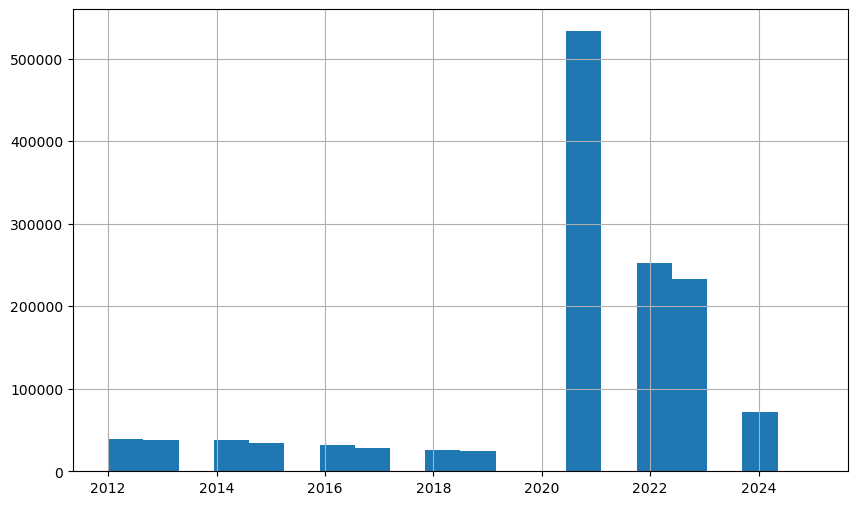

In [45]:
# grafico de valores nulos en combustible por año_archivo
# graficar los años en los que hay valores nulos en combustible_final (histplot)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
resultado_match[resultado_match['combustible_final'].isnull()]['año_archivo'].hist(bins=20)

In [46]:
# Machear regiones

In [47]:
columna_definitiva = ['region', 'tipo_servicio',
       'fecha_ingreso_rnt', 'ano_fabricacion',
       'capacidad', 'año_archivo', 'mes_archivo',
       'fecha_ingreso', 'linea', 'tipo_servicio_normalizado',
       'marca_normalizada', 'modelo_normalizado', 'modelo_base',
       'modelo_match', 'co2_final',
       'combustible_final']

resultado_match_final = resultado_match[columna_definitiva]
resultado_match_final

,region,tipo_servicio,fecha_ingreso_rnt,ano_fabricacion,capacidad,año_archivo,mes_archivo,fecha_ingreso,linea,tipo_servicio_normalizado,marca_normalizada,modelo_normalizado,modelo_base,modelo_match,co2_final,combustible_final
0,1.0,TAXI COLECTIVO RURAL,2007-06-26,2007.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",187.0,Gasolina
1,1.0,TAXI COLECTIVO RURAL,2019-10-07,2015.0,NaN,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
2,1.0,TAXI COLECTIVO RURAL,2012-05-15,2012.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
3,1.0,TAXI COLECTIVO RURAL,2011-08-30,2011.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
4,1.0,TAXI COLECTIVO RURAL,2013-05-03,2013.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778255,16.0,AUTOMOVIL URBANO TAXI BÁSICO,2008-02-13-00.00.00.000000,2008.0,4.0,2019,diciembre,NaN,NaN,TAXI BÁSICO,nissan,v16 ex saloon 1 6,v16,NaN,NaN,NaN
7778256,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2014-05-26-00.00.00.000000,2014.0,4.0,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris sedan gli 1 5,new,NaN,NaN,NaN
7778257,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2019-11-29-00.00.00.000000,2020.0,NaN,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,peugeot,301 allure hdi,301,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",167.0,Gasolina
7778258,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2019-11-29-00.00.00.000000,2020.0,NaN,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris,new,NaN,NaN,NaN


In [48]:
regiones_chile = {
    1: "Arica y Parinacota",
    2: "Tarapacá",
    3: "Antofagasta",
    4: "Atacama",
    5: "Coquimbo",
    6: "Valparaíso",
    7: "Metropolitana de Santiago",
    8: "O’Higgins",
    9: "Maule",
    10: "Ñuble",
    11: "Biobío",
    12: "La Araucanía",
    13: "Los Ríos",
    14: "Los Lagos",
    15: "Aysén",
    16: "Magallanes y la Antártica Chilena"
}
resultado_match_final['region_nombre'] = resultado_match_final['region'].map(regiones_chile)
resultado_match_final

C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\369666352.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado_match_final['region_nombre'] = resultado_match_final['region'].map(regiones_chile)


,region,tipo_servicio,fecha_ingreso_rnt,ano_fabricacion,capacidad,año_archivo,mes_archivo,fecha_ingreso,linea,tipo_servicio_normalizado,marca_normalizada,modelo_normalizado,modelo_base,modelo_match,co2_final,combustible_final,region_nombre
0,1.0,TAXI COLECTIVO RURAL,2007-06-26,2007.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",187.0,Gasolina,Arica y Parinacota
1,1.0,TAXI COLECTIVO RURAL,2019-10-07,2015.0,NaN,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,Arica y Parinacota
2,1.0,TAXI COLECTIVO RURAL,2012-05-15,2012.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,Arica y Parinacota
3,1.0,TAXI COLECTIVO RURAL,2011-08-30,2011.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,Arica y Parinacota
4,1.0,TAXI COLECTIVO RURAL,2013-05-03,2013.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent rb gl 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,Arica y Parinacota
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778255,16.0,AUTOMOVIL URBANO TAXI BÁSICO,2008-02-13-00.00.00.000000,2008.0,4.0,2019,diciembre,NaN,NaN,TAXI BÁSICO,nissan,v16 ex saloon 1 6,v16,NaN,NaN,NaN,Magallanes y la Antártica Chilena
7778256,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2014-05-26-00.00.00.000000,2014.0,4.0,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris sedan gli 1 5,new,NaN,NaN,NaN,Magallanes y la Antártica Chilena
7778257,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2019-11-29-00.00.00.000000,2020.0,NaN,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,peugeot,301 allure hdi,301,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",167.0,Gasolina,Magallanes y la Antártica Chilena
7778258,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2019-11-29-00.00.00.000000,2020.0,NaN,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris,new,NaN,NaN,NaN,Magallanes y la Antártica Chilena


In [54]:
nomina_vehiculos[(nomina_vehiculos['marca_normalizada'] == 'suzuki') & (nomina_vehiculos['modelo_normalizado'].str.contains('fronx'))]

,id_modelo,marca,modelo,transmision,combustible,propulsion,cilindrada,carroceria,emisiones_de_co2_g_km,co2_combinado,...,co2_prom_grupo,co2_prom_cil,co2_final,marca_normalizada,modelo_normalizado,cilindrada_extraida,combustible_inferido,marca_norm,modelo_norm,modelo_base
5875,6607,Suzuki,Fronx 1.5 ISG AT,A,Gasolina,Combustión,1.5,Hatchback,120.0,NaN,...,160.532759,158.102917,120.0,suzuki,fronx_1_5_isg_at,NaN,None,suzuki,fronx 1 5 isg at,fronx
5876,6608,Suzuki,Fronx 1.5 ISG MT,M,Gasolina,Combustión,1.5,Hatchback,118.0,NaN,...,160.532759,158.102917,118.0,suzuki,fronx_1_5_isg_mt,NaN,None,suzuki,fronx 1 5 isg mt,fronx


In [49]:
resultado_match_final.to_csv("matches.csv", index=False)

In [50]:
# Coerce object columns to pandas nullable string dtype to avoid mixed types (floats/NaN) that break pyarrow
for col in resultado_match_final.select_dtypes(include=["object"]).columns:
	resultado_match_final[col] = resultado_match_final[col].astype("string")

# Ensure specific known problematic column is string (defensive)
if "linea" in resultado_match_final.columns:
	resultado_match_final["linea"] = resultado_match_final["linea"].astype("string")

resultado_match_final.to_parquet("matches.parquet", index=False)

C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\1159006240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado_match_final[col] = resultado_match_final[col].astype("string")
C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\1159006240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado_match_final[col] = resultado_match_final[col].astype("string")
C:\Users\hiros\AppData\Local\Temp\ipykernel_17552\1159006240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [51]:
asdasd

NameError: name 'asdasd' is not defined

In [ ]:
regiones_clean_unique = regiones_clean.drop_duplicates(
    subset=['region', 'año_archivo', 'mes_archivo']
).copy()

# 2. Normalizar 'region' para evitar falsos vacíos
regiones_clean_unique['region_1'] = (
    regiones_clean_unique['region_1']
    .astype(str)
    .str.strip()
    .replace(['', 'nan', 'None', 'NaN'], np.nan)
)

# 3. Eliminar filas donde region sea NaN
regiones_clean_unique = regiones_clean_unique.dropna(subset=['region_1'])

regiones_clean_unique


,region,region_1,año_archivo,mes_archivo
496,15,DE ARICA Y PARINACOTA,2021,abril
501,16,DEL BIOBIO,2021,abril
124924,10,DE LOS LAGOS,2021,enero
124928,11,AISEN DEL GENERAL CARLOS IBA?EZ DEL CAMPO,2021,enero
124929,13,METROPOLITANA DE SANTIAGO,2021,enero
...,...,...,...,...
2804727,12,de Valparaíso,2025,septiembre
2805661,13,de Coquimbo,2025,septiembre
2827018,14,de Coquimbo,2025,septiembre
2828017,15,de Arica y Parinacota,2025,septiembre


In [ ]:
#merge en regiones, segun id_cliente, año_region, mes_region

resultado_match = resultado_match.merge(regiones_clean, on=['region','año_archivo','mes_archivo'], how='left')
resultado_match

KeyboardInterrupt: 

In [ ]:
columna_definitiva = ['region', 'tipo_servicio',
       'fecha_ingreso_rnt', 'ano_fabricacion',
       'capacidad', 'año_archivo', 'mes_archivo',
       'fecha_ingreso', 'linea', 'tipo_servicio_normalizado',
       'marca_normalizada', 'modelo_normalizado', 'modelo_base',
       'modelo_match', 'co2_final',
       'combustible_final','region_1']

resultado_match_final = resultado_match[columna_definitiva]
resultado_match_final

,region,tipo_servicio,fecha_ingreso_rnt,ano_fabricacion,capacidad,año_archivo,mes_archivo,fecha_ingreso,linea,tipo_servicio_normalizado,marca_normalizada,modelo_normalizado,modelo_base,modelo_match,co2_final,combustible_final,region_1
0,1.0,TAXI COLECTIVO RURAL,2007-06-26,2007.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",187.0,Gasolina,NaN
1,1.0,TAXI COLECTIVO RURAL,2007-06-26,2007.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",187.0,Gasolina,DE TARAPACA
2,1.0,TAXI COLECTIVO RURAL,2007-06-26,2007.0,4.0,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent gl 1 5,accent,"Accent GL 1,5 Lts. SOHC Sedán 4P. T/M Motor Otto",187.0,Gasolina,DE ANTOFAGASTA
3,1.0,TAXI COLECTIVO RURAL,2019-10-07,2015.0,NaN,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,NaN
4,1.0,TAXI COLECTIVO RURAL,2019-10-07,2015.0,NaN,2021,abril,NaN,NaN,TAXI COLECTIVO RURAL,hyundai,accent 1 6,accent,"Accent RB 1,6 Lts. DOHC Sedán 4P. T/M 6 Vel. M...",157.0,Gasolina,DE TARAPACA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28356627,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2019-11-29-00.00.00.000000,2020.0,NaN,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris,new,NaN,NaN,NaN,DEL BIOBIO
28356628,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2019-11-29-00.00.00.000000,2020.0,NaN,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,toyota,new yaris,new,NaN,NaN,NaN,DE ÑUBLE
28356629,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2019-12-26-00.00.00.000000,2020.0,4.0,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,peugeot,301 active pack hdi 92,301,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",167.0,Gasolina,NaN
28356630,16.0,AUTOMOVIL URBANO TAXI COLECTIVO,2019-12-26-00.00.00.000000,2020.0,4.0,2019,diciembre,NaN,NaN,TAXI COLECTIVO URBANO,peugeot,301 active pack hdi 92,301,"301 Allure 1,6 Lts. VTi 115HP Sedán 4P. T/A",167.0,Gasolina,DEL BIOBIO


In [ ]:
resultado_match_final.to_csv("matches.csv", index=False)


KeyboardInterrupt: 